In [1]:
# Auto-reload modules when they change
%load_ext autoreload
%autoreload 2

In [2]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms

# Local imports
from datasets import JunkFoodMulticlassDataset
from qml.models.multiclass import (
    BatchedGPUHybridQuantumMultiClassCNN,
    HybridQuantumMultiClassCNN
)
from qml.ansatz.dense import DenseQCNNAnsatz4

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load Dataset

In [3]:
# Configuration
train_data_folder = "data/data_aug"
test_data_folder = "data/data_noaug"

# Transform
IMAGE_SIZE = 128
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

# Load Datasets
train_dataset = JunkFoodMulticlassDataset(train_data_folder, transform=transform)
full_test_dataset = JunkFoodMulticlassDataset(test_data_folder, transform=transform)

# Determine size of test set to maintain ~80/20 ratio based on training size
# If Train is 80%, then Test should be 25% of Train size (since 20/80 = 1/4)
target_test_size = int(len(train_dataset) * 0.25)
print(f"Training count: {len(train_dataset)}")
print(f"Target Test count (for 80/20 ratio): {target_test_size}")
print(f"Classes: {train_dataset.classes}")
print(f"Num Classes: {train_dataset.num_classes}")

# Creates a random subset of the clean test data
indices = list(range(len(full_test_dataset)))
random.seed(42) # Ensure consistent test set
random.shuffle(indices)
test_dataset = Subset(full_test_dataset, indices[:target_test_size])

print(f"Actual Test count: {len(test_dataset)}")
print(f"Train/Test Ratio: {len(train_dataset)/(len(train_dataset)+len(test_dataset)):.2f}/{len(test_dataset)/(len(train_dataset)+len(test_dataset)):.2f}")

Training count: 4614
Target Test count (for 80/20 ratio): 1153
Classes: ['french_fries', 'fried_chicken', 'hamburger', 'ice_cream', 'junk_food_logo', 'pizza', 'soda']
Num Classes: 7
Actual Test count: 1153
Train/Test Ratio: 0.80/0.20


In [4]:
# Train/test configuration
BATCH_SIZE = 32
SEED = 42

# Create data loaders
torch.manual_seed(SEED)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training on {len(train_dataset)} augmented images, Testing on {len(test_dataset)} clean images.")

Training on 4614 augmented images, Testing on 1153 clean images.


## Create Quantum CNN Model

In [5]:
model = BatchedGPUHybridQuantumMultiClassCNN(
    num_classes=train_dataset.num_classes,
    input_size=IMAGE_SIZE,
    kernel_size=3,
    stride=1,
    pool_size=12,
    encoding='dense',
    ansatz=DenseQCNNAnsatz4(),
    n_qubits=4,
    measurement='x',
    hidden_size=[128, 64, 32]
)

model = model.to(device)

Using lightning.qubit device with 'dense' encoding, DenseQCNNAnsatz4, measurement=PauliX
Using default.qubit device with 'dense' encoding, DenseQCNNAnsatz4, measurement=PauliX


## Setup Training

In [6]:
from notebooks.utils import print_model_parameters

# Display model parameter count
print_model_parameters(model)


MODEL PARAMETER COUNT
Total parameters:                29,157
Trainable parameters:            29,157
Non-trainable parameters:             0

Parameter breakdown by layer:
Layer                                    Parameters      Trainable 
-----------------------------------------------------------------
qconv.q_params                           30              Yes       
classical.1.weight                       18,432          Yes       
classical.1.bias                         128             Yes       
classical.4.weight                       8,192           Yes       
classical.4.bias                         64              Yes       
classical.7.weight                       2,048           Yes       
classical.7.bias                         32              Yes       
classical.10.weight                      224             Yes       
classical.10.bias                        7               Yes       


In [7]:
from notebooks.multiclass_trainer import MultiClassTrainer

# Training configuration
LEARNING_RATE = 0.005
EPOCHS = 15

# Loss function and optimizer
# BCEWithLogitsLoss is correct for multi-label (multi-hot) classification
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Create trainer
trainer = MultiClassTrainer(
    criterion=criterion,
    device=device,
    log_interval=10
)

## Train Model
With test evaluation after each epoch

In [8]:
results = trainer.train(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    epochs=EPOCHS,
    test_loader=test_loader
)

Evaluating: 100%|██████████| 37/37 [01:35<00:00,  2.59s/it]


Epoch 1: Train Loss=0.0548, Train Acc=0.8544 | Test Loss=0.0510, Test Acc=0.8673


Evaluating: 100%|██████████| 37/37 [01:37<00:00,  2.63s/it]


Epoch 2: Train Loss=0.0526, Train Acc=0.8624 | Test Loss=0.0495, Test Acc=0.8673


Evaluating: 100%|██████████| 37/37 [01:45<00:00,  2.84s/it]


Epoch 3: Train Loss=0.0518, Train Acc=0.8631 | Test Loss=0.0494, Test Acc=0.8673


Evaluating: 100%|██████████| 37/37 [01:35<00:00,  2.59s/it]


Epoch 4: Train Loss=0.0515, Train Acc=0.8629 | Test Loss=0.0490, Test Acc=0.8673


Evaluating: 100%|██████████| 37/37 [01:34<00:00,  2.56s/it]


Epoch 5: Train Loss=0.0512, Train Acc=0.8629 | Test Loss=0.0488, Test Acc=0.8673


Evaluating: 100%|██████████| 37/37 [01:33<00:00,  2.53s/it]


Epoch 6: Train Loss=0.0509, Train Acc=0.8631 | Test Loss=0.0483, Test Acc=0.8673


Evaluating: 100%|██████████| 37/37 [01:32<00:00,  2.51s/it]


Epoch 7: Train Loss=0.0508, Train Acc=0.8628 | Test Loss=0.0476, Test Acc=0.8706


Evaluating: 100%|██████████| 37/37 [01:33<00:00,  2.54s/it]


Epoch 8: Train Loss=0.0502, Train Acc=0.8625 | Test Loss=0.0471, Test Acc=0.8700


Evaluating: 100%|██████████| 37/37 [01:33<00:00,  2.52s/it]


Epoch 9: Train Loss=0.0499, Train Acc=0.8625 | Test Loss=0.0468, Test Acc=0.8698


Evaluating: 100%|██████████| 37/37 [01:34<00:00,  2.57s/it]


Epoch 10: Train Loss=0.0492, Train Acc=0.8638 | Test Loss=0.0456, Test Acc=0.8708


Evaluating: 100%|██████████| 37/37 [01:32<00:00,  2.50s/it]


Epoch 11: Train Loss=0.0486, Train Acc=0.8643 | Test Loss=0.0458, Test Acc=0.8744


Evaluating: 100%|██████████| 37/37 [01:32<00:00,  2.50s/it]


Epoch 12: Train Loss=0.0482, Train Acc=0.8657 | Test Loss=0.0449, Test Acc=0.8723


Evaluating: 100%|██████████| 37/37 [01:34<00:00,  2.55s/it]


Epoch 13: Train Loss=0.0477, Train Acc=0.8657 | Test Loss=0.0443, Test Acc=0.8750


Evaluating: 100%|██████████| 37/37 [01:33<00:00,  2.53s/it]


Epoch 14: Train Loss=0.0470, Train Acc=0.8670 | Test Loss=0.0434, Test Acc=0.8735


Evaluating: 100%|██████████| 37/37 [01:35<00:00,  2.58s/it]

Epoch 15: Train Loss=0.0466, Train Acc=0.8668 | Test Loss=0.0428, Test Acc=0.8788


## Train results

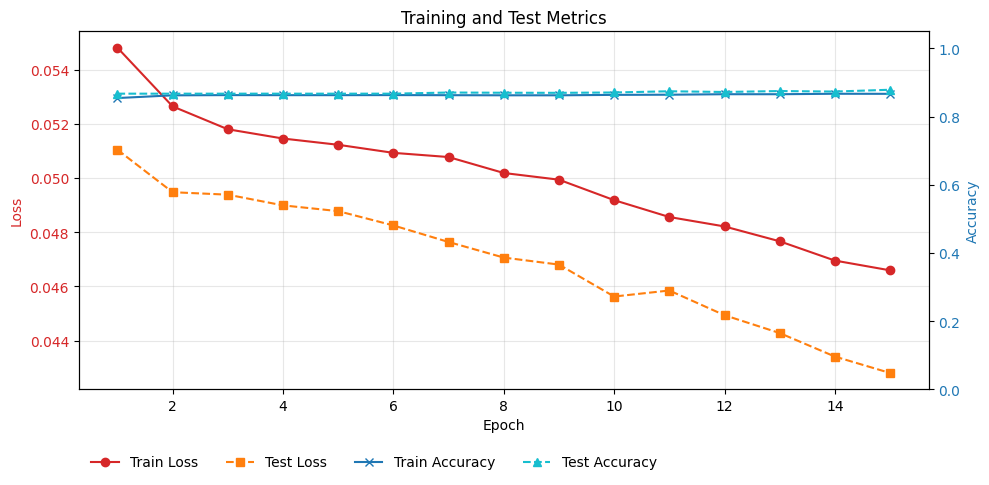

In [9]:
from notebooks.utils import plot_loss_and_accuracy

plot_loss_and_accuracy(
    losses=results['train_loss'],
    accuracies=results['train_acc'],
    test_losses=results['test_loss'],
    test_accuracies=results['test_acc']
)

Evaluating: 100%|██████████| 37/37 [01:55<00:00,  3.13s/it]


Final Test Results:
Test Loss: 0.0428
Test Accuracy: 0.8788


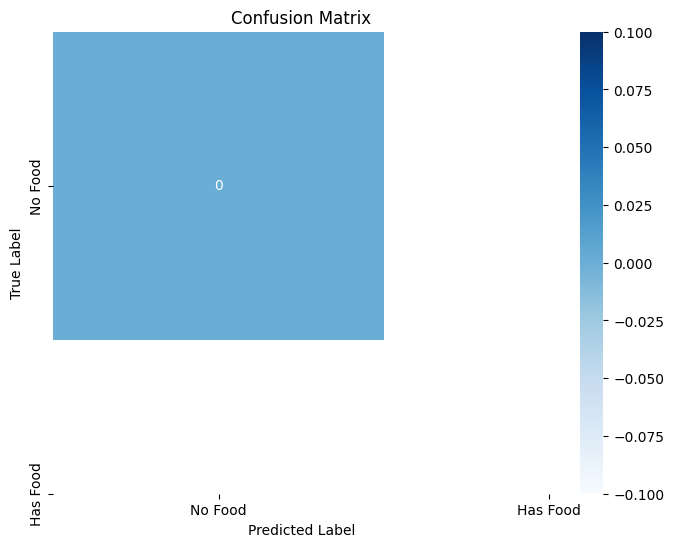

ValueError: not enough values to unpack (expected 4, got 1)

In [ ]:
(test_loss, test_acc), confusion_matrix = trainer.evaluate(model, test_loader)

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")